In [1]:
#MobileNet v3


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081)),
])

transform_test = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081)),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False, num_workers=2)

classes = trainset.classes


==> Preparing data..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


5 - five  1 - one  1 - one  3 - three


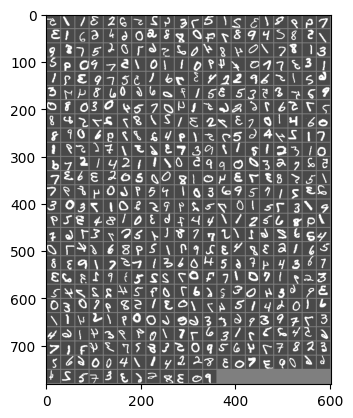

In [3]:
#view data

import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images, nrow=20)
matplotlib_imshow(img_grid, one_channel=False)
print('  '.join(classes[labels[j]] for j in range(4)))

In [4]:
# Model
print('==> Building model..')

model = torchvision.models.mobilenet_v3_large()
model = model.to(device)


if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True



criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0)


==> Building model..


In [5]:
# Training
def train(epochs):
    model.train()
    for epoch in range(epochs):

        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            #loss = nn.NLLLoss(output,target)
            loss.backward()

            optimizer.step()
            if batch_idx % 100 == 0:
                done = batch_idx * len(data)
                percentage = 100. * batch_idx / len(trainloader)
                print(f'Train Epoch: {epoch} [{done:5}/{len(trainloader.dataset)} ({percentage:3.0f}%)]  Loss: {loss.item():.6f}')

        test(trainloader)
        test(testloader)


def test(loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            #test_loss += nn.NLLLoss(output, target).item()
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)')
    return accuracy

In [6]:
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(model, (3,28,28), as_strings=True, backend='pytorch',
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))


DataParallel(
  5.48 M, 100.000% Params, 0.0 Mac, 0.000% MACs, 
  (module): MobileNetV3(
    5.48 M, 100.000% Params, 0.0 Mac, 0.000% MACs, 
    (features): Sequential(
      2.97 M, 54.203% Params, 0.0 Mac, 0.000% MACs, 
      (0): Conv2dNormActivation(
        464, 0.008% Params, 0.0 Mac, 0.000% MACs, 
        (0): Conv2d(432, 0.008% Params, 0.0 Mac, 0.000% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, 0.001% Params, 0.0 Mac, 0.000% MACs, 16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
      )
      (1): InvertedResidual(
        464, 0.008% Params, 0.0 Mac, 0.000% MACs, 
        (block): Sequential(
          464, 0.008% Params, 0.0 Mac, 0.000% MACs, 
          (0): Conv2dNormActivation(
            176, 0.003% Params, 0.0 Mac, 0.000% MACs, 
            (0): Conv2d(144, 0.003% Params, 0.0 Mac, 0.000% MACs, 16, 16, kernel_size=(3, 3), stride

In [7]:

train(100)
test(trainloader)
test(testloader)
     

Train Epoch: 0 [    0/60000 (  0%)]  Loss: 6.909781
Train Epoch: 0 [51200/60000 ( 85%)]  Loss: 0.402390
Test set: Average loss: 0.0092, Accuracy: 6131/60000 (10.22%)
Test set: Average loss: 0.0233, Accuracy: 1010/10000 (10.10%)
Train Epoch: 1 [    0/60000 (  0%)]  Loss: 4.667708
Train Epoch: 1 [51200/60000 ( 85%)]  Loss: 2.314324
Test set: Average loss: 0.0045, Accuracy: 6265/60000 (10.44%)
Test set: Average loss: 0.0115, Accuracy: 1028/10000 (10.28%)
Train Epoch: 2 [    0/60000 (  0%)]  Loss: 2.300310
Train Epoch: 2 [51200/60000 ( 85%)]  Loss: 2.301282
Test set: Average loss: 0.0046, Accuracy: 10909/60000 (18.18%)
Test set: Average loss: 0.0116, Accuracy: 1828/10000 (18.28%)
Train Epoch: 3 [    0/60000 (  0%)]  Loss: 2.328313
Train Epoch: 3 [51200/60000 ( 85%)]  Loss: 2.305414
Test set: Average loss: 0.0046, Accuracy: 5918/60000 (9.86%)
Test set: Average loss: 0.0116, Accuracy: 958/10000 (9.58%)
Train Epoch: 4 [    0/60000 (  0%)]  Loss: 2.306197
Train Epoch: 4 [51200/60000 ( 85%)]  L

98.78

In [8]:
def softmax_by_row(logits, T = 1.0):
    mx = np.max(logits, axis=-1, keepdims=True)
    exp = np.exp((logits - mx)/T)
    denominator = np.sum(exp, axis=-1, keepdims=True)
    return exp/denominator

def classifier_performance(model, train_loader, test_loader):

    output_train_benign = []
    train_label = []
    for num, data in enumerate(train_loader):
        images,labels = data
        image_tensor= images.to(device)
        img_variable = Variable(image_tensor, requires_grad=True)
        output = model.forward(img_variable)

        train_label.append(labels.numpy())
        output_train_benign.append(softmax_by_row(output.data.cpu().numpy(),T = 1))


    train_label = np.concatenate(train_label)
    output_train_benign=np.concatenate(output_train_benign)

    test_label = []
    output_test_benign = []

    for num, data in enumerate(test_loader):
        images,labels = data

        image_tensor= images.to(device)
        img_variable = Variable(image_tensor, requires_grad=True)

        output = model.forward(img_variable)

        test_label.append(labels.numpy())
        output_test_benign.append(softmax_by_row(output.data.cpu().numpy(),T = 1))


    test_label = np.concatenate(test_label)
    output_test_benign=np.concatenate(output_test_benign)


    train_acc1 = np.sum(np.argmax(output_train_benign,axis=1) == train_label.flatten())/len(train_label)
    test_acc1 = np.sum(np.argmax(output_test_benign,axis=1) == test_label.flatten())/len(test_label)

    print('Accuracy: ', (train_acc1, test_acc1))

    return output_train_benign, output_test_benign, train_label, test_label




def inference_via_confidence(confidence_mtx1, confidence_mtx2, label_vec1, label_vec2):
    
    #----------------First step: obtain confidence lists for both training dataset and test dataset--------------
    confidence1 = []
    confidence2 = []
    acc1 = 0
    acc2 = 0
    for num in range(confidence_mtx1.shape[0]):
        confidence1.append(confidence_mtx1[num,label_vec1[num]])
        if np.argmax(confidence_mtx1[num,:]) == label_vec1[num]:
            acc1 += 1
            
    for num in range(confidence_mtx2.shape[0]):
        confidence2.append(confidence_mtx2[num,label_vec2[num]])
        if np.argmax(confidence_mtx2[num,:]) == label_vec2[num]:
            acc2 += 1
    confidence1 = np.array(confidence1)
    confidence2 = np.array(confidence2)
    
    print('model accuracy for training and test-', (acc1/confidence_mtx1.shape[0], acc2/confidence_mtx2.shape[0]) )
    
    
    #sort_confidence = np.sort(confidence1)
    sort_confidence = np.sort(np.concatenate((confidence1, confidence2)))
    max_accuracy = 0.5
    best_precision = 0.5
    best_recall = 0.5
    for num in range(len(sort_confidence)):
        delta = sort_confidence[num]
        ratio1 = np.sum(confidence1>=delta)/confidence_mtx1.shape[0]
        ratio2 = np.sum(confidence2>=delta)/confidence_mtx2.shape[0]
        accuracy_now = 0.5*(ratio1+1-ratio2)
        if accuracy_now > max_accuracy:
            max_accuracy = accuracy_now
            best_precision = ratio1/(ratio1+ratio2)
            best_recall = ratio1
    print('membership inference accuracy is:', max_accuracy)
    return max_accuracy


In [9]:

from torch.autograd import Variable
import os
import numpy as np
import math 
import scipy
import sys  

output_train, output_test, train_label, test_label = classifier_performance(model, trainloader, testloader)
inference_accuracy=inference_via_confidence(output_train, output_test, train_label, test_label)
print("Maximum Accuracy:",inference_accuracy)

Accuracy:  (0.9902666666666666, 0.9878)
model accuracy for training and test- (0.9902666666666666, 0.9878)
membership inference accuracy is: 0.5016083333333334
Maximum Accuracy: 0.5016083333333334
